# Predicting severe accidents using Machine Learning

# 1.Introduction
According to the CDC, road accidents are the third top reason responsible for human mortality, so much so that 170 thousand people died of accidents in the US during the year 2017. The WHO statistics also show that road accidents are one of the top 10 reasons responsible for human mortalities. In fact, according to WHO, the counts of road accident-related mortalities have risen up to 2 million people in 2016 (ranked 8th cause of death) from the year 2000's 1.5 million people(ranked 10th cause of death).
As a Data scientist, I believe a model that predicts road accident severity based on the given appropriate attributes could improve and/or possibly revolutionize these companies/organizations' actions.

Let's get started! First we get the Dataset!

In [ ]:
!wget -O data.csv https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv
  

### Now let's import the libraries we need and then we take a look at the raw dataset.

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
df = pd.read_csv('data.csv')
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


# 2.Data
## now let's clean the data according to the report/blog post.
### The unnecessary columns will be dropped and the inconsistencies in the dataset will be resolved.

In [130]:
df = df.drop(['LOCATION', 'OBJECTID','COLDETKEY', 'INCKEY', 'X', 'Y', 'REPORTNO', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
              'SDOT_COLCODE','ST_COLCODE', 'SDOTCOLNUM', 'SEVERITYCODE.1', 'SEVERITYDESC', 'STATUS', 'INTKEY', 'SEGLANEKEY', 'CROSSWALKKEY',
              'INATTENTIONIND','SDOT_COLDESC', 'ST_COLDESC','INCDATE','INCDTTM'], axis = 1)

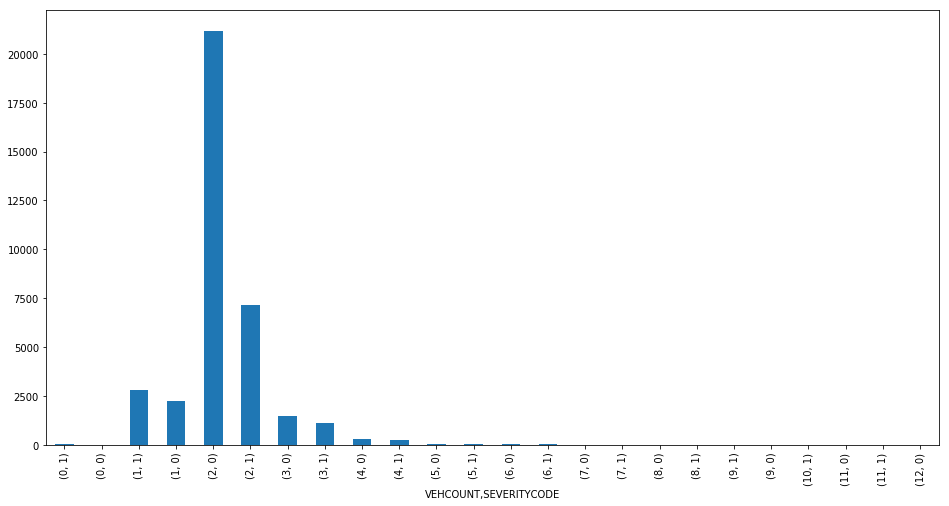

In [131]:
df['SPEEDING'].replace(np.nan, 'N', inplace = True)
#df['INATTENTIONIND'].replace(np.nan, 'N', inplace = True)
df['UNDERINFL'].replace('1', 'Y', inplace = True)
df['UNDERINFL'].replace('0', 'N',inplace = True)
df['PEDROWNOTGRNT'].replace(np.nan, 'N',inplace = True)
df['SEVERITYCODE'].replace([1,2],[0,1], inplace = True)
df.dropna(inplace = True)

(df.groupby('VEHCOUNT')['SEVERITYCODE'].value_counts() / 5).plot.bar(figsize = (16,8))

# 3.Methodology
## 3.1 Feature selection

The features will be chosen or dropped depending on being eligible for training the model. The basis of this feature evaluation process is explained in detail in the report/blog post.

### for now let's look at some insightful visualizations!

SPEEDING  SEVERITYCODE
N         0               120569
          1                53133
Y         0                 5701
          1                 3492
Name: SEVERITYCODE, dtype: int64


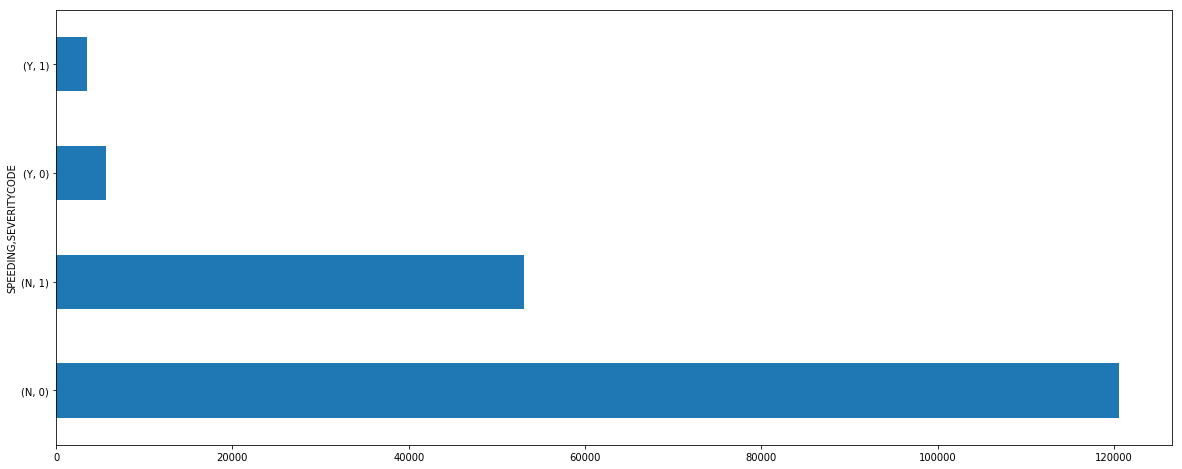

In [132]:
print(df.groupby('SPEEDING')['SEVERITYCODE'].value_counts())
df.groupby('SPEEDING')['SEVERITYCODE'].value_counts().plot.barh(figsize = (20,8))

In [133]:
df.drop(['PERSONCOUNT'],axis = 1)
to_binary_list = ['PEDROWNOTGRNT','SPEEDING','HITPARKEDCAR','UNDERINFL']
for i in to_binary_list :
    df[i].replace(['Y','N'],[1,0],inplace = True)

In [134]:
to_onehot_list = ['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND']
for i in to_onehot_list :
    df = pd.concat([df,pd.get_dummies(df[i])],axis = 1)
    df.drop([i],axis = 1, inplace = True)
df.head()
df = df.sample(frac = 1)
zerodf = df[df['SEVERITYCODE'] == 0]
onedf = df[df['SEVERITYCODE'] == 1]
df = pd.concat([zerodf.iloc[: onedf.shape[0], :],onedf],axis = 0)
df = df.sample(frac = 1)
zerodf.shape, onedf.shape, df.shape

((126270, 58), (56625, 58), (113250, 58))

### As you can see, we shuffle the data before and after balancing to mitigate any bias issues.
### Then we normalize the data set and divide it into train and test subsets.
### you can see the final clean dataset below.

In [135]:
from sklearn.preprocessing import StandardScaler as STSC
y = df['SEVERITYCODE'].values
df.drop(['SEVERITYCODE'],axis = 1,inplace = True)
X = df.values
X = STSC().fit_transform(X)

In [136]:

from sklearn.model_selection import train_test_split as TTS
X_train, X_test, y_train, y_test = TTS(X,y, test_size = .1) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape
df.head()

,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,Alley,Block,...,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,Other,Unknown
178800,2,0,0,2,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
9183,5,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
172889,2,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
43706,2,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
134536,2,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report

## 3.2 Modelling 
### Here we use GridCV to find the best combination of parameters and hyper parameters.
#### The best model (estimator) will then be used to create results.

In [138]:
from sklearn.linear_model import LogisticRegression as LR
parameters = [{'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C' : [0.001, 0.005, 0.01, 0.05, 0.1,0.5]}]
logGrid = GSCV(LR(),parameters, cv = 5, scoring = 'f1')
logGrid.fit(X_train,y_train)
bestLR = logGrid.best_estimator_
bestLR.score(X_test,y_test)

0.702251655629139

In [139]:
print(f1_score(y_test,bestLR.predict(X_test)))
f1_score(y_train, bestLR.predict(X_train))

0.7310575849417771


0.7296155658909212

# 4.Results
### below you can see the results of balanced vs unbalanced performance on train and test sets. 
#### Notice how the balanced data set allowed the model to achieve "almost" double the previous f1 score. 

In [142]:
pd.DataFrame({'f1 test' : [0.73 , .43],
             'f1 train' : [0.7296, .428],
             'acc test' : [0.70, .75],
             'balance' : ['balanced', 'unbalanced']}).set_index('balance')

,f1 test,f1 train,acc test
balance,,,
balanced,0.73,0.7296,0.70
unbalanced,0.43,0.4280,0.75


# 5.Discussion
While my model was able to learn a great deal of information from the dataset, I believe there's a lot of ways in which the dataset can be improved. For example, I believe that if the data was more specific in terms of technical info, and less specific in terms of physical location info, my model could've been able to learn much more and thus perform much better.
With all that said, I have a few suggestions for the people/organizations that want to create a predictor model using this dataset and then deploy it for the city of Seattle. Those people could use Seattle specific features like unique IDs of intersections and incident descriptions dictionary of Washington state to make a model that performs better in Seattle.

# 6.Conclusion
Although the model we made was not able to perform as well as we expected, it learned a great deal about how features correlate with accident severity. I think that using the predictions of my model (those predictions that were made with high levels of confidence) could help the drivers of self-driving vehicles to drive more safely and thus the rate of severe road accidents could be significantly reduced.

# 7.Refrences
For the blog post, visit : https://www.linkedin.com/pulse/new-ai-can-predict-accident-severity-mehregan-karbasi